# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

import datetime

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
457001,637,7,2014-05-18,0,0,0,0,0,0,d,c,9790.0,NaN,NaN,1,31.0,2009.0,"Feb,May,Aug,Nov"


# 1.0. DESCRICAO DOS DADOS

In [4]:
# Original dataframe copy
df1 = df_raw.copy()

## 1.1. Rename columns

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Changing write pattern to snakecase

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Renaming
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimension

In [8]:
print( 'Number of rows: {}'.format(df1.shape[0]))
print( 'Number of rows: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of rows: 18


## 1.3. Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
# First, we must analyze what every variable and data with NA values

# competition_distance
## Assumption: if it is NA, maybe it is because the store doesnt have an near competitor
## What has been done: CONSIDER AN EXTREME DISTANT RANGE FROM NEAR COMPETITOR

df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000 if math.isnan(x) else x )

# competition_open_since_month
## Assumption: there are two main reasons that this data is NA: (i) the store doesnt have a near competitor or
## (ii) the store has an near competitor, but it the opening data is unknown, either it is older than the store or data is unavailable
## What has been done: CONSIDER THE SAME MONTH THAT THE STORE HAS BEEN OPEN (because it maybe older than the store)

# Error: EDIT Solved
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#Alternative: 
#df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

# competition_open_since_year
## Same ideia from variable above

#Error: EDIT: Solved
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#Alternative: 
#df1.competition_open_since_year.fillna(df1.date.dt.month, inplace=True)



# promo2
## Doesnt have any NA

# promo2_since_week
## Assumption: it is possible that the NA values are due to lack of participation/extension of any promotions.
## What I think should have been done: ALL NA VALUES ARE CONSIDERED "0", AS THE STORE IS NOT EXTENDING PROMOTIONS
## What has actually been done: CONSIDER THE SAME VALUE AS THE DATE
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year
## Same logic as above
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval
## The problem here is that, it is hard to understand the way it has been inserted.
## What has been done: (i) Analyze the interval of the promo; (ii) Check if sale month is in promo_interval
## if it is, (iii) apply value 1 to new column is_promo, else 0.
## This way, it will be easy to check if sale is inside a promotion interval.

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [13]:
df1.sample(5).T

,553865,28042,63047,304901,518869
store,496,168,608,324,65
day_of_week,4,1,5,7,7
date,2014-02-20 00:00:00,2015-07-06 00:00:00,2015-06-05 00:00:00,2014-10-19 00:00:00,2014-03-23 00:00:00
sales,7192,6693,10794,0,0
customers,788,723,1029,0,0
open,1,1,1,0,0
promo,1,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,a,a,a


## 1.6. Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# Competion and promos since are portrayed as float types, while it should be int type.

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int64','float64', 'datetime64[ns]'])

num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
361025,351,3,6403,548,1,1,0,5290.0,11,2012,1,5,2013,1
421161,477,4,0,0,0,1,1,770.0,7,2010,1,35,2010,0
659111,932,1,9909,884,1,1,0,15700.0,11,2013,1,13,2010,0
882959,665,3,0,0,0,1,0,90.0,12,2012,1,14,2011,0
365681,329,5,6059,574,1,0,1,1310.0,6,1990,1,22,2012,0


### 1.7.1. Numerical Attributes

In [17]:
# Central tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate

n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
                  
n.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


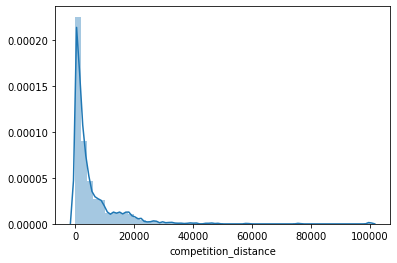

In [18]:
sns.distplot( df1['competition_distance'] )

### 1.7.2. Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

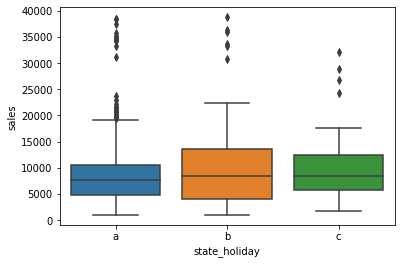

In [20]:
filter1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(x='state_holiday', y='sales', data=filter1)

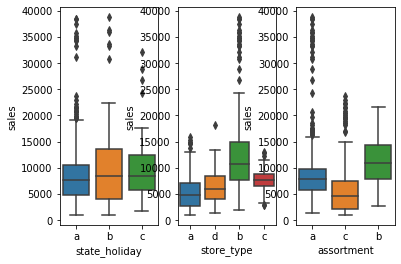

In [21]:
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=filter1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=filter1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=filter1)

# 2.0. FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
192652,873,1,2015-02-09,3074,427,1,0,0,1,a,a,2040.0,11,2008,0,2,2015,0,Fev,0
6875,186,6,2015-07-25,3916,364,1,0,0,0,a,a,290.0,10,2011,1,40,2014,"Jan,Apr,Jul,Oct",Jul,1
501453,489,2,2014-04-08,6084,620,1,0,0,0,a,a,14960.0,11,2013,1,37,2009,"Jan,Apr,Jul,Oct",Apr,1
903215,851,6,2013-04-13,4920,471,1,0,0,0,d,c,2330.0,4,2013,1,49,2014,"Mar,Jun,Sept,Dec",Apr,0
202114,300,6,2015-01-31,8383,1048,1,0,0,0,a,c,120.0,4,2009,1,1,2012,"Jan,Apr,Jul,Oct",Jan,1


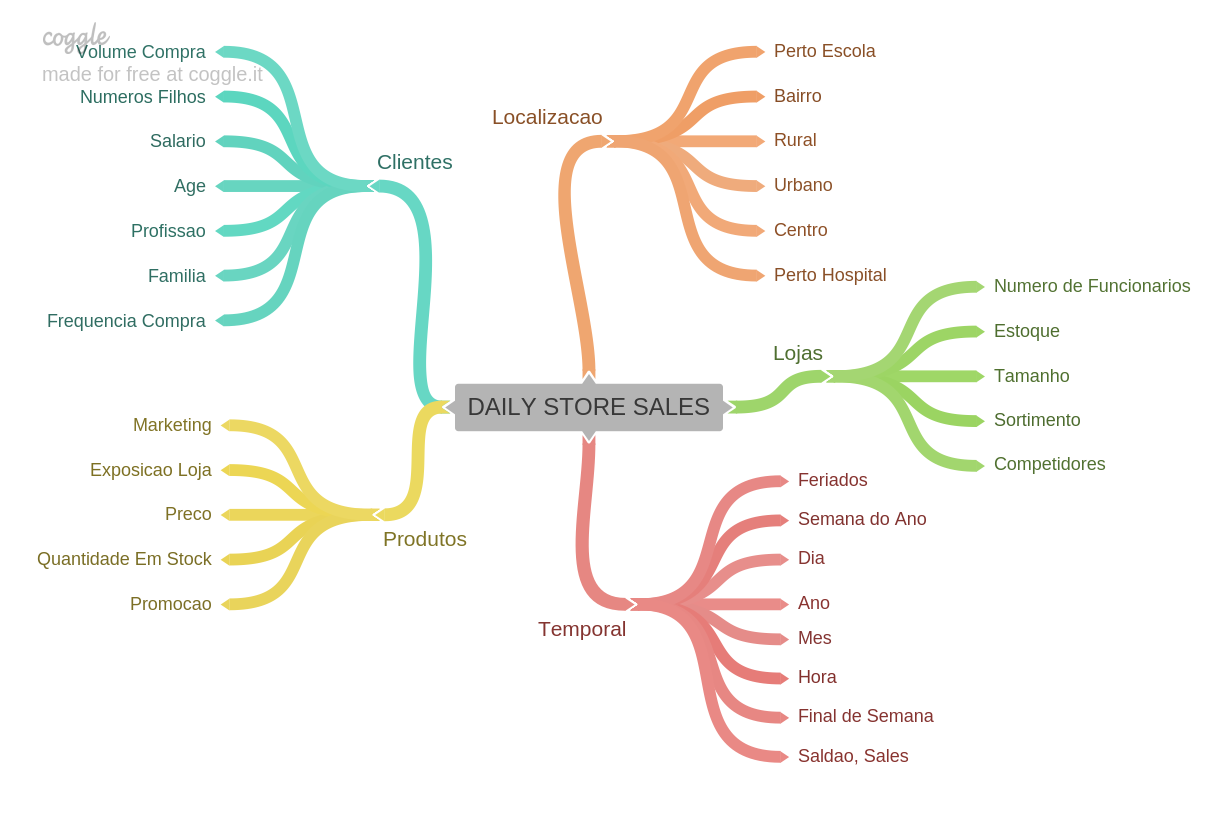

In [23]:
Image('img/MindMapHypothesis.png')

## 2.1. Hypothesis mental map

### 2.1.1. Stores Hypothesis

**1.** Stores with more employees **should** have more sales

**2.** Stores with more product stock **should** have more sales

**3.** Smaller stores **should** have less sales

**4.** Bigger stores **should** have more sales

**5.** Stores with more product options **should** have more sales

### 2.1.2. Product Hypothesis

**1.** Stores with more marketing investment **should** have more sales

**2.** Stores that exposes more the products **should** sell more those products

**3.** Stores with smaller product prices **should** have more sales of those products

**4.** Stores with smaller product prices for the longest possible time **should** have more sales

### 2.1.3. Time Hypothesis

**1.** Stores with more holidays **should** have less sales

**2.** Stores that opens at the first 6 months **should** have more sales

**3.** Stores that opens at the weekends **should** have more sales

## 2.2. Hypothesis priorization

The hypothesis that should have prioritized are the ones with the data available at the start of the proccess

**1.** Stores with more product options **should** have more sales

**2.** Stores with closer competitors **should** have less sales

**3.** Stores with competitors open for the longest time **should** have more sales


**4.** Stores with more active promotions **should** have more sales

**5.** Stores with more promotion days **should** have more sales

**6.** Stores with consecutive promotions **should** have more sales


**7.** Stores open at Xmas **should** have more sales

**8.** Stores sales **should** grow through the years

**9.** Stores **should** sell more at the second half of the year

**10.** Stores **should** sell more after the tenth day of each month

**11.** Stores **should** sell less at the weekends

**12.** Stores **should** sell less at school holydays

## 2.3 Feature Engineering

In [24]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#weekofyear
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competitionsince
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days ).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [25]:
df2.sample(5).T

,3119,768672,572424,483350,81813
store,890,108,100,226,419
day_of_week,3,7,1,4,2
date,2015-07-29 00:00:00,2013-08-11 00:00:00,2014-02-03 00:00:00,2014-04-24 00:00:00,2015-05-19 00:00:00
sales,6725,0,9958,5144,6148
customers,462,0,786,555,935
open,1,0,1,1,1
promo,1,0,1,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,1,0
store_type,a,d,d,a,c


# 3.0. VARIABLE FILTERING

In [26]:
df3 = df2.copy()

## 3.1. Line Filtering

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column FIltering

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [29]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

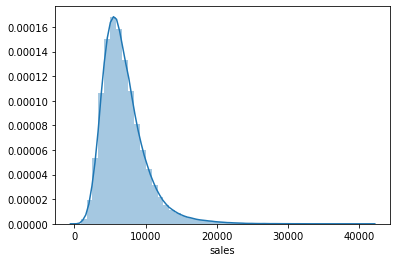

In [30]:
sns.distplot(df4['sales'])

# The more the graph seems like a bell curve, the better.
# It is because some models and algorithms are based on normal shape curve
# Applying functions such as log makes the graph looks more like the bell.

### 4.1.2. Numerical Variable

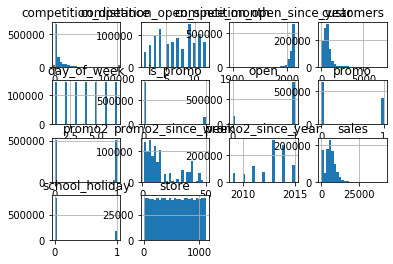

In [31]:
num_attributes.hist(bins=25)

plt.show()

### 4.1.3 Categorical Variable

In [32]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
177683,0,a,a,"Jan,Apr,Jul,Oct",Fev
367839,0,d,c,"Feb,May,Aug,Nov",Aug
344511,0,a,a,"Jan,Apr,Jul,Oct",Sep
949176,0,b,b,0,Mar
445910,0,a,c,0,May


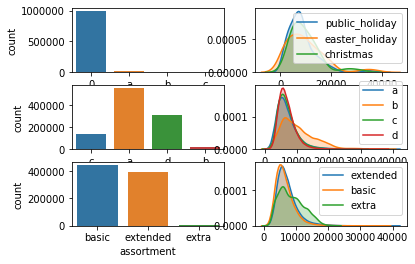

In [33]:


# State holiday
plt.subplot(3, 2, 1)
#a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(cat_attributes['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)





# Store type
plt.subplot(3, 2, 3)
sns.countplot(cat_attributes['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)





## 4.2. Bivariate Analysis

### Hypothesis **1.** Stores with more product options **should** have more sales

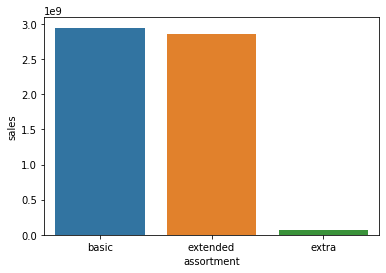

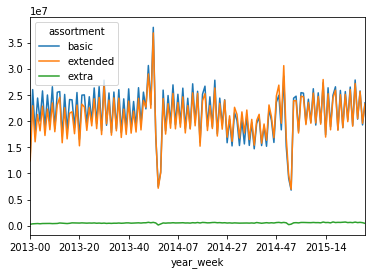

In [37]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
#sns.barplot(x='assortment', y='sales', data= aux2);

**False** Results shows that the basic assortment store type, sells **more** than a store with more assortment

### Hypothesis **2.** Stores with closer competitors **should** have less sales

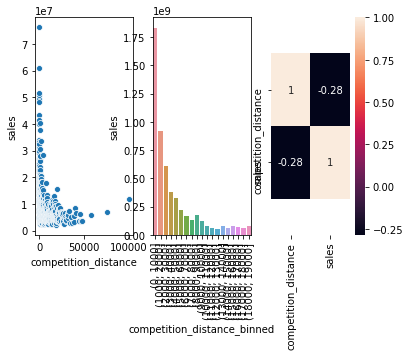

In [43]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (1, 3, 1)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
#sns.barplot(x='competition_distance_binned', y='sales', data= aux1);
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data= aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**False** Stores with closer competitors actually sells **more** than stores with distant competitors

### Hypothesis **3.** Stores with competitors open for the longest time **should** have more sales

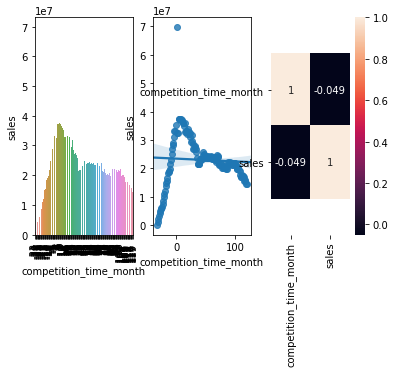

In [66]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux4 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0) ]
sns.barplot(x='competition_time_month', y='sales', data=aux4)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux4)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux4.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**False** stores with longer competition sells **less**. However, the behavior of sales is different before competition starts and after it starts.

## 4.3. Multivariate Analysis